# melt rate feedbacks

*preliminary ideas:* can we use the ISOMIP+ data to dig into the relative effect of thermal driving and friction velocity on melt rate?

Also, notice that the average friction velocity has a minimum of c_drag^0.5*u_tide and it's average gets close to that, meaning that this somewhat arbitrary u_tide has a big impact on the melt.

In [168]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm
from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

In [169]:
## folder where the isomip-plus github repo is located
# baserepo = '/g/data/x77/cy8964/isomip-plus/'
baserepo = '../../'
## folder where you downloaded the zipped Google Drive data
basedrive = '/mnt/c/Users/Qin/DataDisk/ISOMIP+/ISOMIP+Data/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)


In [170]:


#12 model colours for 12 models, generated using https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=12
modelcolours=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']


In [171]:
# Constants

rho_fw = 1000 #kg/m3
L = 3.34e5 #J/kg
rho_sw = 1028 #kg/m3
Cw = 3974

GammaT={'COCO':2.5e-2,
'FVCOM':.2,
'MITgcm BAS':1.9e-2,
'MITgcm BAS CoupledV3':2.1e-2,
'MITgcm JPL':3.25e-2,
'MOM6':4.5e-2,
'MOM6 SIGMA ZSTAR':8.7e-2,
'MPAS-Ocean':1.46e-2,
'NEMO-CNRS':4e-2,
'NEMO-UKESM1is':1.4e-1,
'POP2x':1.1e-1,
'ROMSUTAS':5e-2}

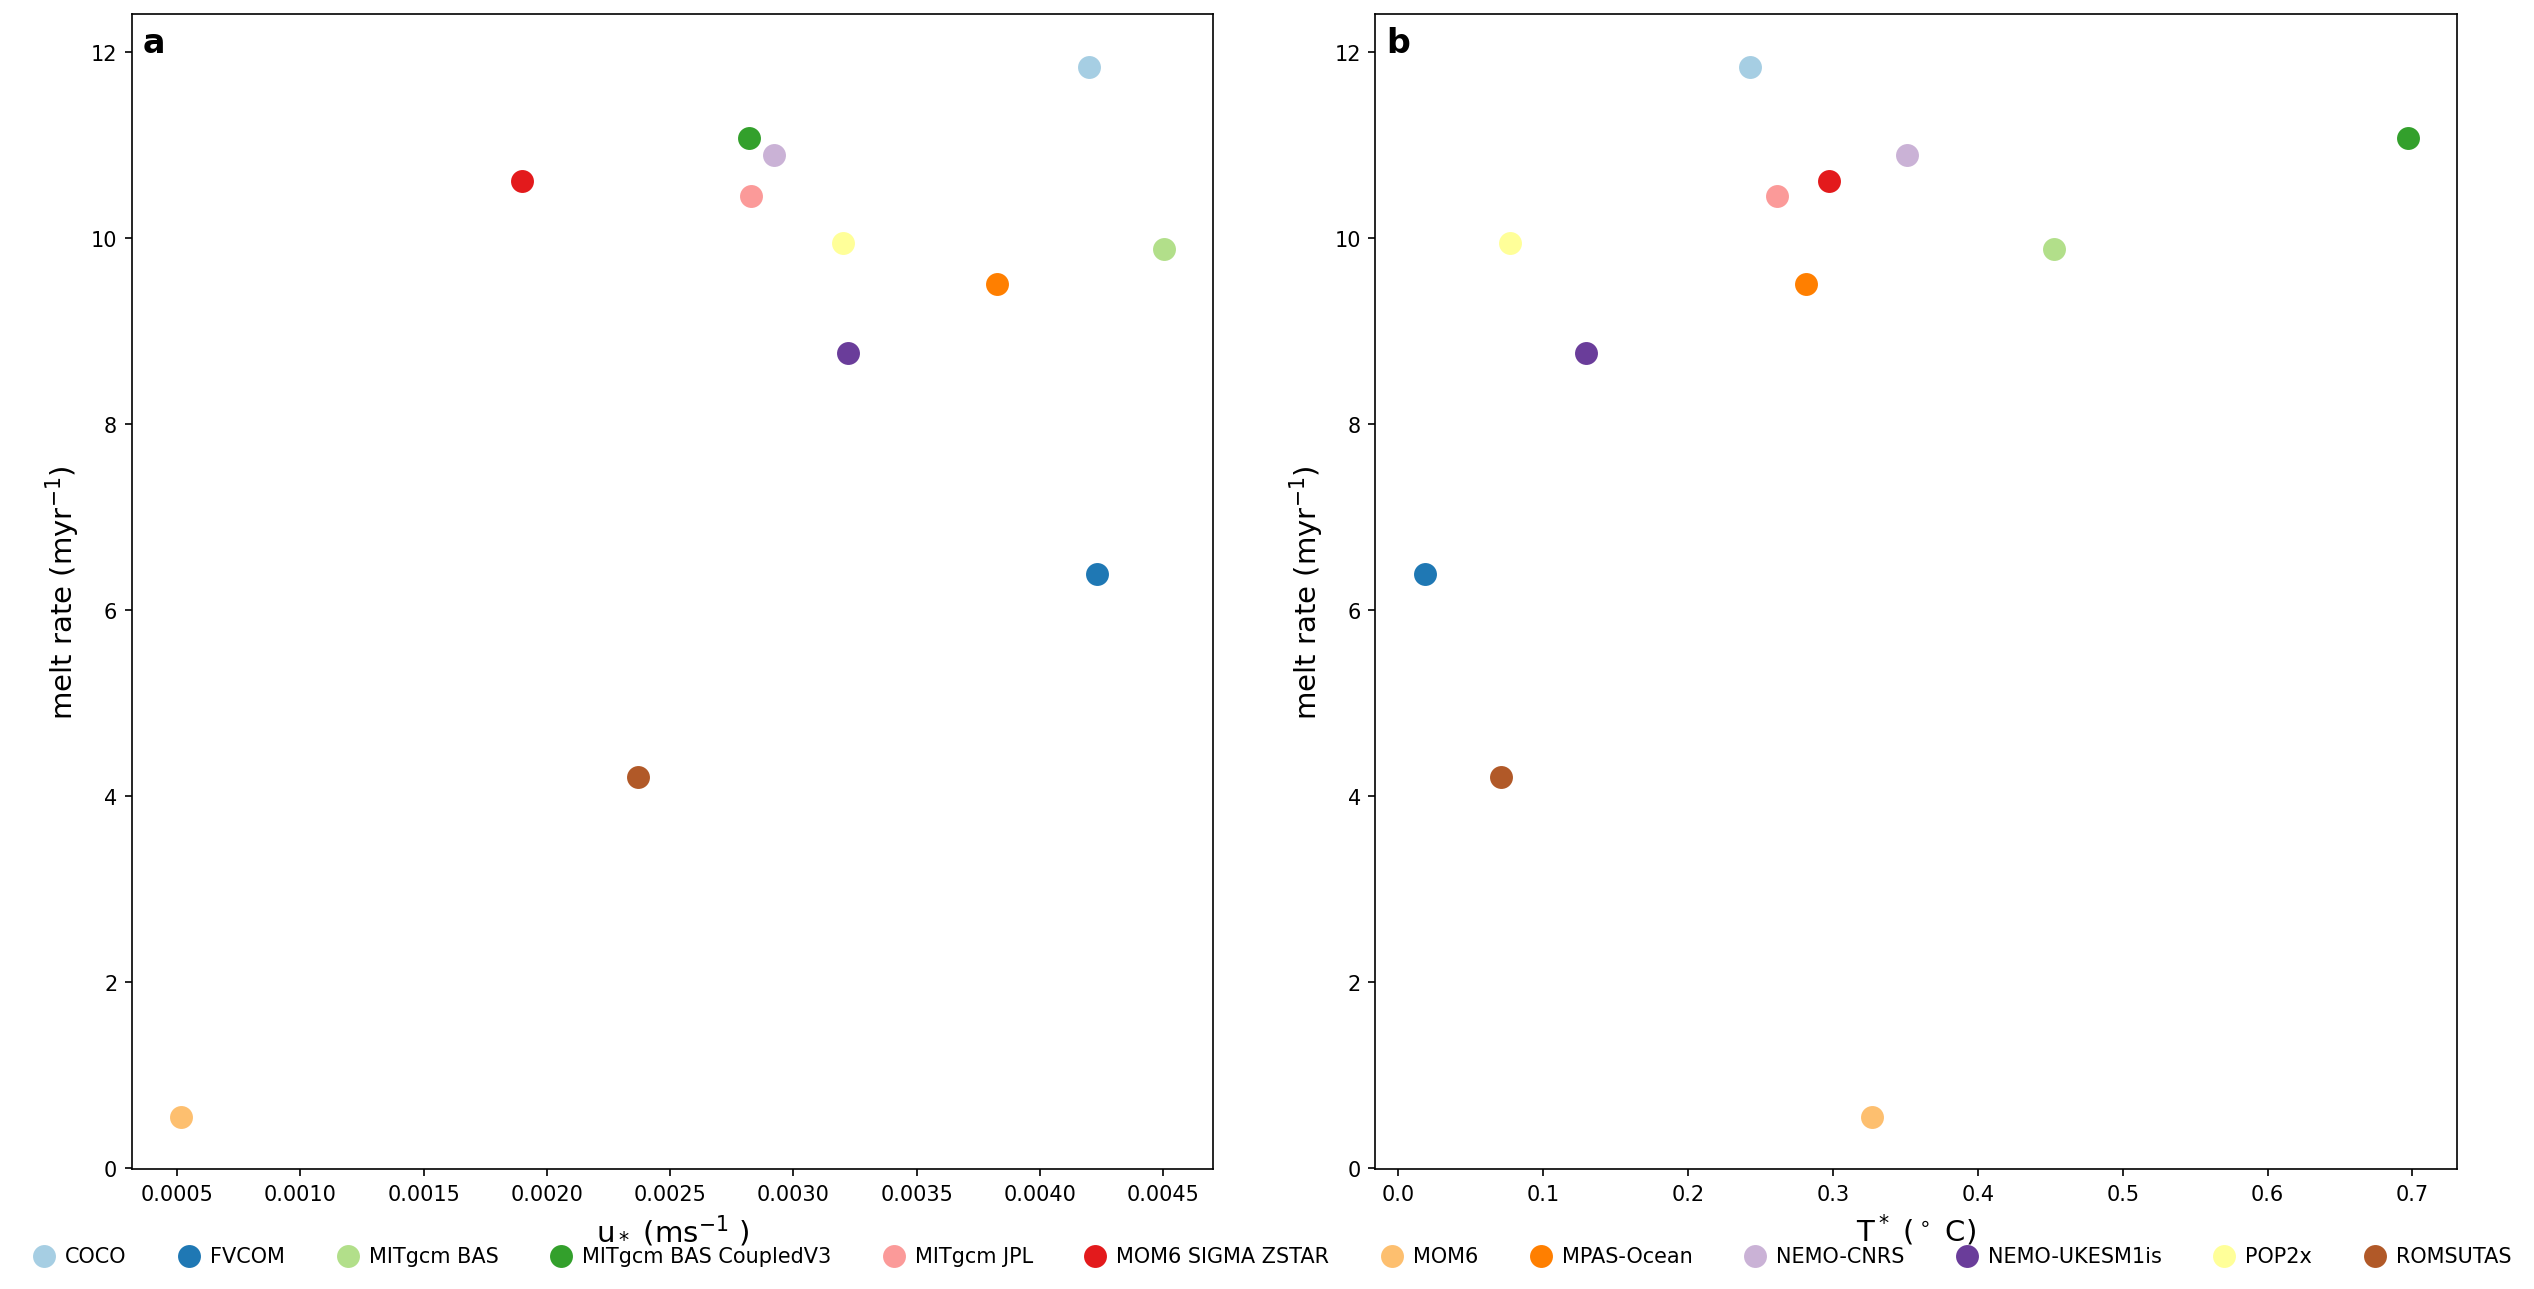

In [172]:

# scatter plot of melt rates aganst T^* and u_* for Ocean1_COM
expt = Ocean1_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

length = len(expt)
#fig = plt.figure(figsize=(10,7),facecolor='w',dpi = 150)
gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.15, hspace=0.05)
fig = plt.figure(figsize=(20,10),facecolor='w',dpi = 150)
ax=fig.add_subplot(gs[0])

for i in np.arange(length):
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    fr = data.frictionVelocity
    mr = data.meltRate*365*24*60*60 # use this and .where() to mask out parts of domain that aren't melting

    # Mask out parts of the domain that aren't melting
    mr_masked = mr.where(mr < 1e36)#.where(mr != 0)
    fr_masked = fr.where(mr < 1e36)#.where(mr != 0)
    
    # Select the last 12 months
    mr_last_12 = mr_masked.isel(nTime=slice(-13, None))
    fr_last_12 = fr_masked.isel(nTime=slice(-13, None))
    
    # Compute the mean over the last 12 months across 'nx' and 'ny'
    mr_time_mean = mr_last_12.mean(['nx', 'ny', 'nTime'])
    fr_time_mean = fr_last_12.mean(['nx', 'ny', 'nTime'])
   
    #plt.plot(fr_time_mean, mr_time_mean, 'o', label=labels[i],color=modelcolours[i])
    ss = plt.scatter(fr_time_mean, mr_time_mean,label = labels[i], s = 100,color=modelcolours[i])
plt.text(0.01,0.99,'a', fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')
#plt.ylim(0,0.01)
plt.xlabel(r'u$_*$ ($\mathrm{ms^{-1}}$ )',fontsize=14)
plt.ylabel(r'melt rate ($\mathrm{myr^{-1}}$)',fontsize=14)

ax=fig.add_subplot(gs[1])

for i in np.arange(length):
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    thr = data.thermalDriving
    mr = data.meltRate*365*24*60*60 # use this and .where() to mask out parts of domain that aren't melting
   # Mask out parts of the domain that aren't melting
    mr_masked = mr.where(mr < 1e36)#.where(mr != 0)
    thr_masked = thr.where(mr < 1e36)#.where(mr != 0)
    
    # Select the last 12 months
    mr_last_12 = mr_masked.isel(nTime=slice(-13, None))
    thr_last_12 = thr_masked.isel(nTime=slice(-13, None))
    
    # Compute the mean over the last 12 months across 'nx' and 'ny'
    mr_time_mean = mr_last_12.mean(['nx', 'ny', 'nTime'])
    thr_time_mean = thr_last_12.mean(['nx', 'ny', 'nTime'])
    
    ss = plt.scatter(thr_time_mean, mr_time_mean,label = labels[i], s = 100,color=modelcolours[i])
plt.text(0.01,0.99,'b', fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')    
plt.xlabel(r'T$^*$ ($\mathrm{^\circ}$ C)',fontsize=14)
plt.ylabel(r'melt rate ($\mathrm{myr^{-1}}$)',fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.05),frameon=False,ncol=length,handletextpad=0.01)



Text(0, 0.5, '$\\mathrm{Melt\\_div\\_constants (^\\circ C ms^{-1} )}$')

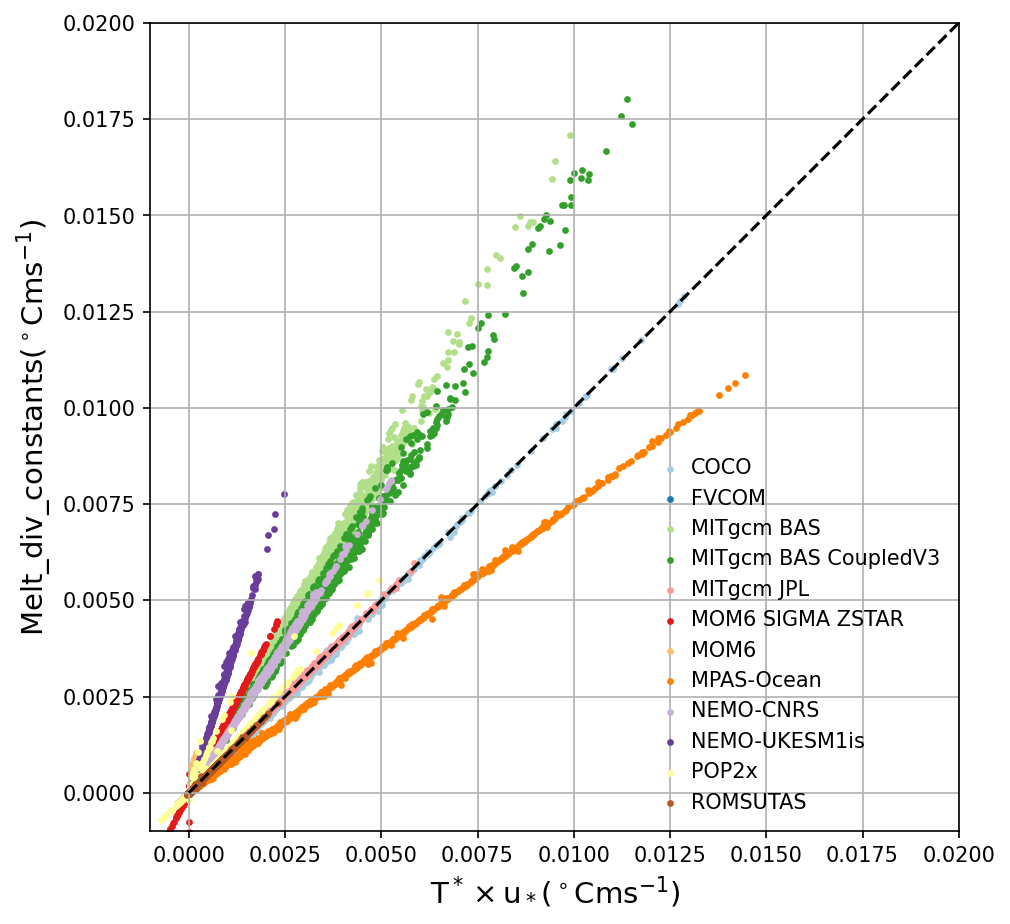

In [173]:
# scatter plot of melt rates divided by constants aganst T^* times u_* for Ocean1_COM

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.15, hspace=0.05)
fig = plt.figure(figsize=(10,7),facecolor='w',dpi = 150)
ax=fig.add_subplot(gs[0])

for i in np.arange(length):

    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
    melt_av = (melt.where(melt<1e36))
    tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
    tstar_av = (tstar.where(tstar<1e36))
    ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
    ustar_av = (ustar.where(ustar<1e36))
    melt_div_constants = melt_av*rho_fw*L/(rho_sw*GammaT[labels[i]]*Cw)
    ax.scatter(melt_div_constants, tstar_av*ustar_av,s=5,color=modelcolours[i])
    ax.scatter(melt_div_constants[-1], tstar_av[-1]*ustar_av[-1], s=5,label=labels[i],color=modelcolours[i])
    
ax.plot((0,0.02),(0,.02),'k--')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),frameon=False,ncol=length/2,handletextpad=0.01)
ax.legend(loc='lower right',frameon=False,handletextpad=0.01)

ax.set_xlim((-.001,0.02))
ax.set_ylim((-.001,0.02))
ax.set_aspect('equal')
ax.grid()
plt.xlabel(r'$\mathrm{T^*\times u_* (^\circ C  ms^{-1} )}$',fontsize=14)
plt.ylabel(r'$\mathrm{Melt\_div\_constants (^\circ C ms^{-1} )}$',fontsize=14)

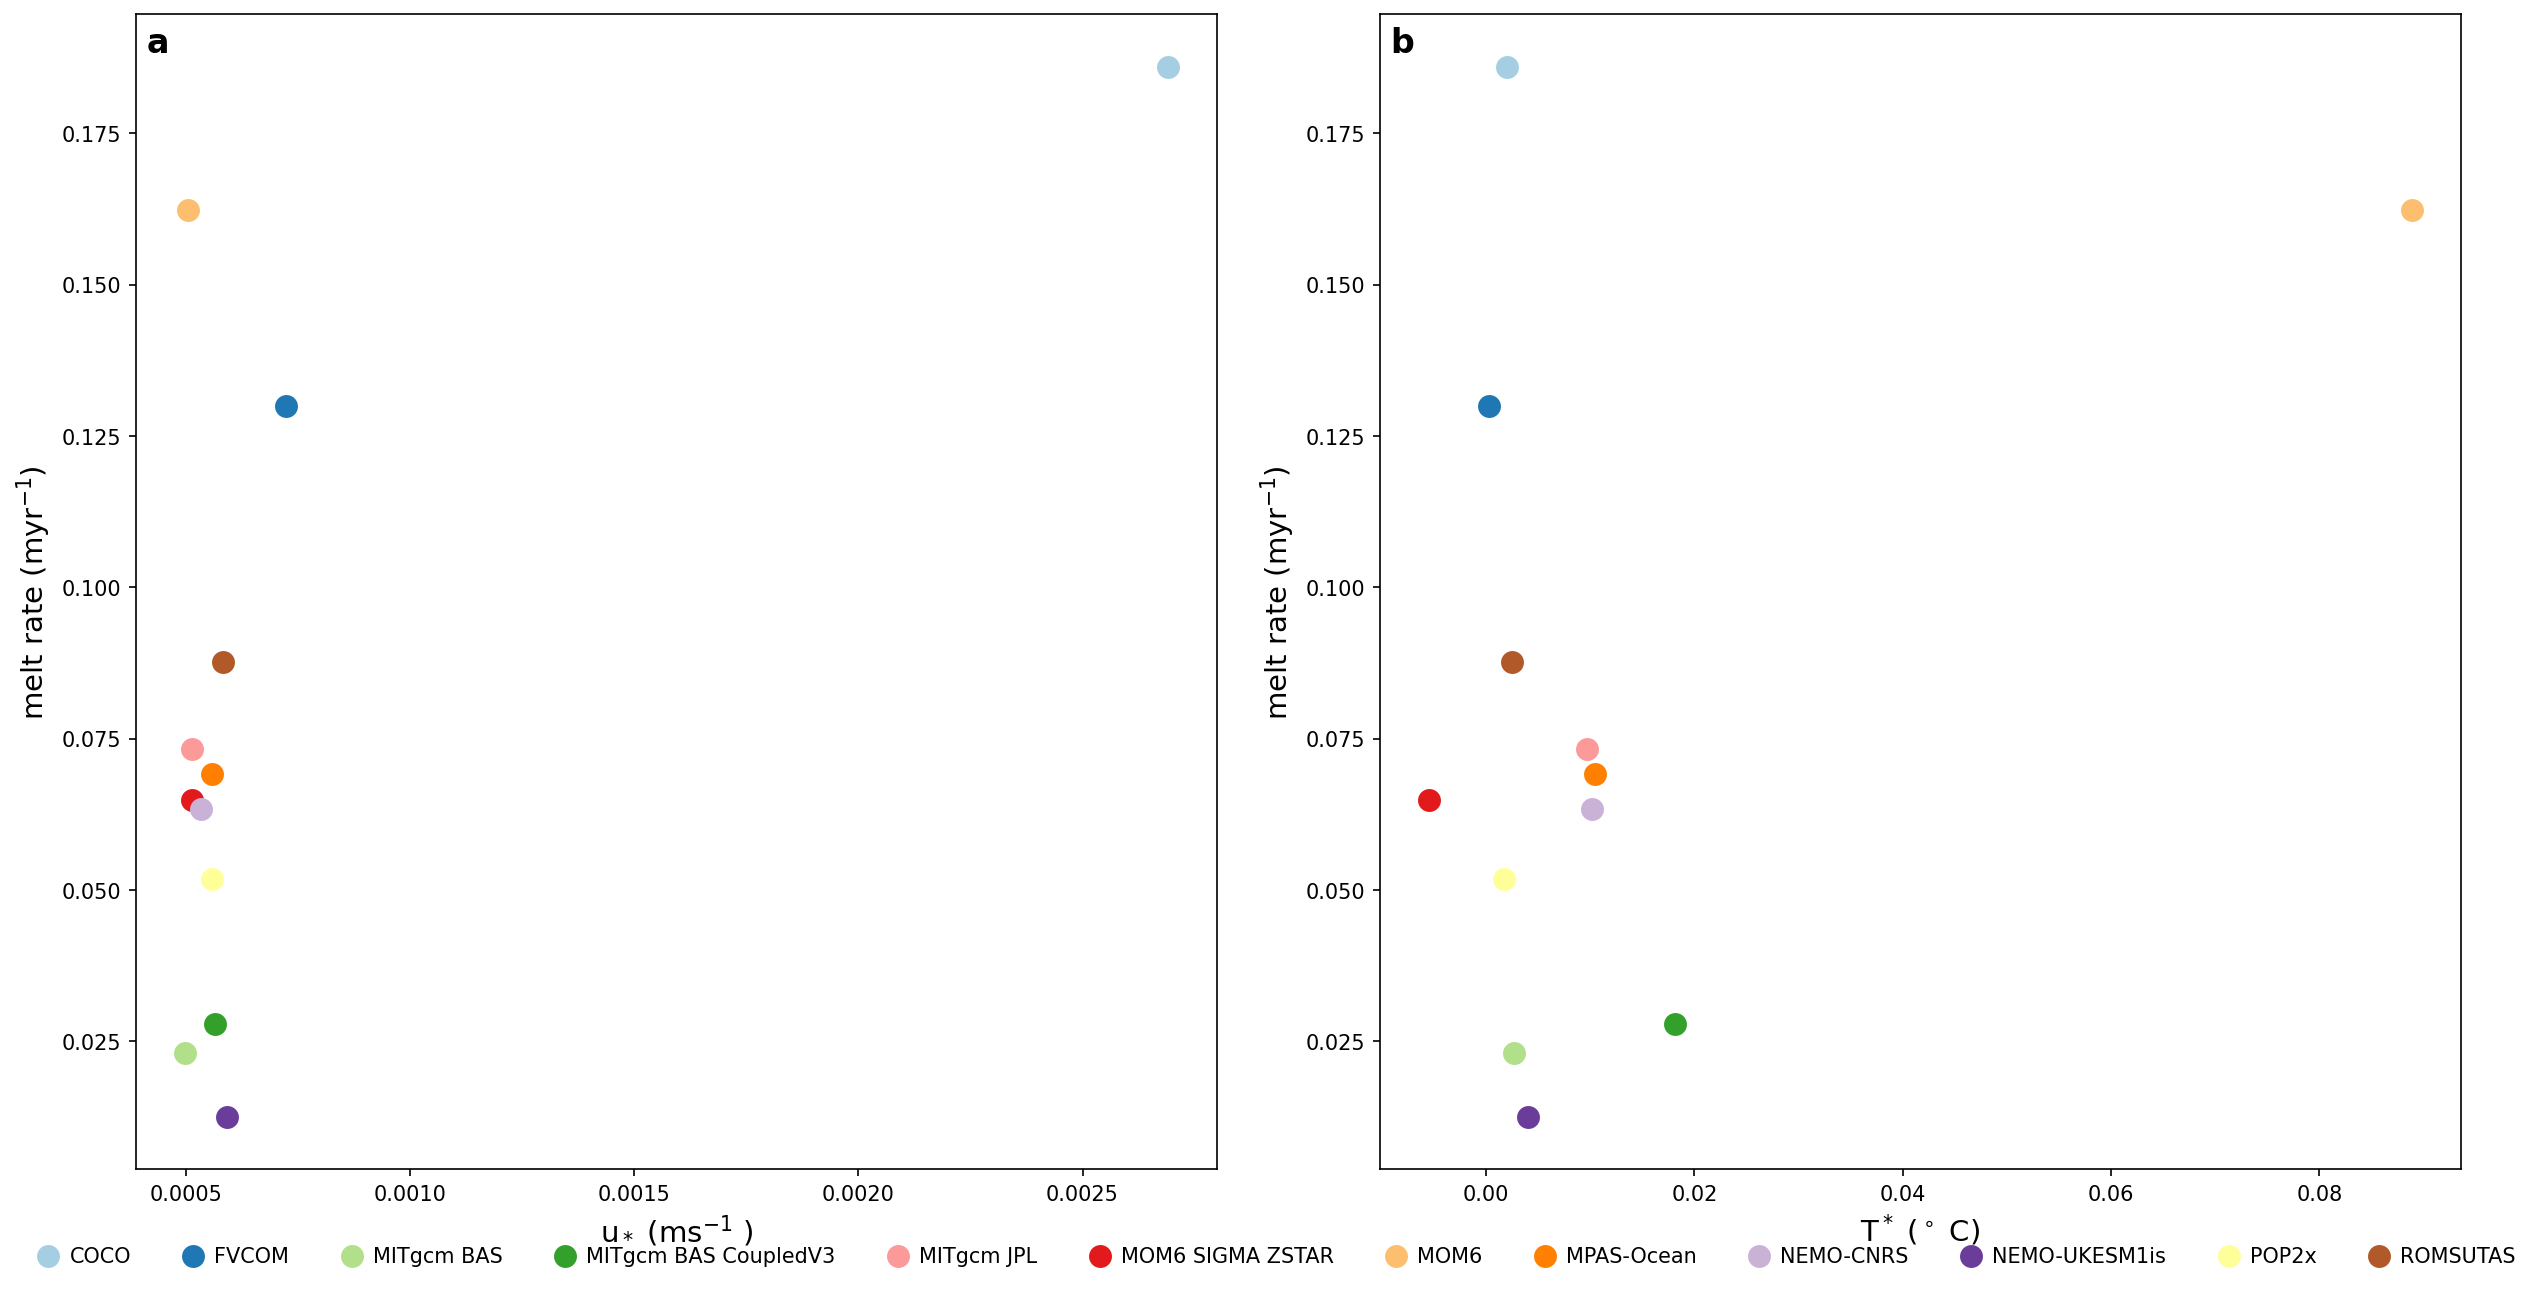

In [174]:
# scatter plot of melt rates aganst T^* and u_* for Ocean2_COM
expt = Ocean2_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

length = len(expt)
#fig = plt.figure(figsize=(10,7),facecolor='w',dpi = 150)
gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.15, hspace=0.05)
fig = plt.figure(figsize=(20,10),facecolor='w',dpi = 150)
ax=fig.add_subplot(gs[0])

for i in np.arange(length):
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    fr = data.frictionVelocity
    mr = data.meltRate*365*24*60*60 # use this and .where() to mask out parts of domain that aren't melting

    # Mask out parts of the domain that aren't melting
    mr_masked = mr.where(mr < 1e36)#.where(mr != 0)
    fr_masked = fr.where(mr < 1e36)#.where(mr != 0)
    
    # Select the last 12 months
    mr_last_12 = mr_masked.isel(nTime=slice(-13, None))
    fr_last_12 = fr_masked.isel(nTime=slice(-13, None))
    
    # Compute the mean over the last 12 months across 'nx' and 'ny'
    mr_time_mean = mr_last_12.mean(['nx', 'ny', 'nTime'])
    fr_time_mean = fr_last_12.mean(['nx', 'ny', 'nTime'])
   
    #plt.plot(fr_time_mean, mr_time_mean, 'o', label=labels[i],color=modelcolours[i])
    ss = plt.scatter(fr_time_mean, mr_time_mean,label = labels[i], s = 100,color=modelcolours[i])
plt.text(0.01,0.99,'a', fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')
#plt.ylim(0,0.01)
plt.xlabel(r'u$_*$ ($\mathrm{ms^{-1}}$ )',fontsize=14)
plt.ylabel(r'melt rate ($\mathrm{myr^{-1}}$)',fontsize=14)

ax=fig.add_subplot(gs[1])

for i in np.arange(length):
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    thr = data.thermalDriving
    mr = data.meltRate*365*24*60*60 # use this and .where() to mask out parts of domain that aren't melting
   # Mask out parts of the domain that aren't melting
    mr_masked = mr.where(mr < 1e36)#.where(mr != 0)
    thr_masked = thr.where(mr < 1e36)#.where(mr != 0)
    
    # Select the last 12 months
    mr_last_12 = mr_masked.isel(nTime=slice(-13, None))
    thr_last_12 = thr_masked.isel(nTime=slice(-13, None))
    
    # Compute the mean over the last 12 months across 'nx' and 'ny'
    mr_time_mean = mr_last_12.mean(['nx', 'ny', 'nTime'])
    thr_time_mean = thr_last_12.mean(['nx', 'ny', 'nTime'])
    
    ss = plt.scatter(thr_time_mean, mr_time_mean,label = labels[i], s = 100,color=modelcolours[i])
plt.text(0.01,0.99,'b', fontsize = 16, transform=ax.transAxes, fontweight='bold', va='top')    
plt.xlabel(r'T$^*$ ($\mathrm{^\circ}$ C)',fontsize=14)
plt.ylabel(r'melt rate ($\mathrm{myr^{-1}}$)',fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.05),frameon=False,ncol=length,handletextpad=0.01)



Text(0, 0.5, '$\\mathrm{Melt\\_div\\_constants (^\\circ C ms^{-1} )}$')

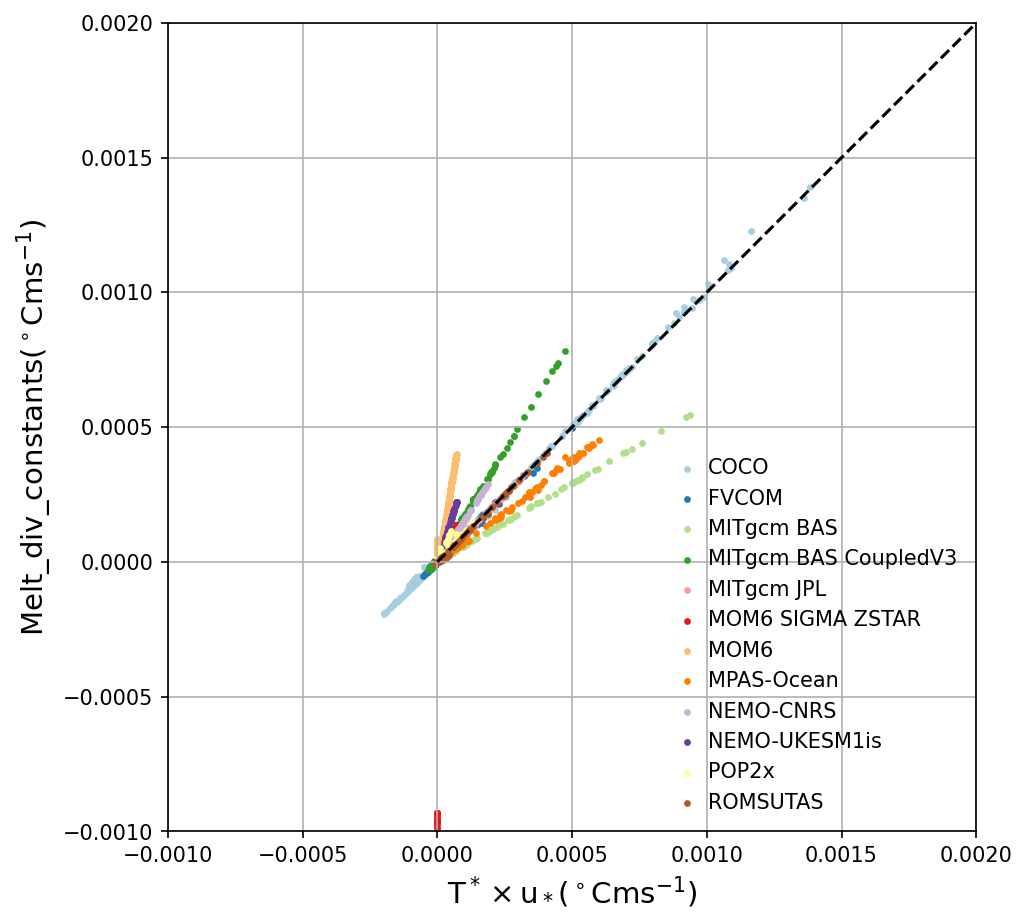

In [175]:
# scatter plot of melt rates divided by constants aganst T^* times u_* for Ocean2_COM

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.15, hspace=0.05)
fig = plt.figure(figsize=(10,7),facecolor='w',dpi = 150)
ax=fig.add_subplot(gs[0])

for i in np.arange(length):

    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
    melt_av = (melt.where(melt<1e36))
    tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
    tstar_av = (tstar.where(tstar<1e36))
    ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
    ustar_av = (ustar.where(ustar<1e36))
    melt_div_constants = melt_av*rho_fw*L/(rho_sw*GammaT[labels[i]]*Cw)
    ax.scatter(melt_div_constants, tstar_av*ustar_av,s=5,color=modelcolours[i])
    ax.scatter(melt_div_constants[-1], tstar_av[-1]*ustar_av[-1], s=5,label=labels[i],color=modelcolours[i])
    
ax.plot((0,0.02),(0,.02),'k--')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),frameon=False,ncol=length/2,handletextpad=0.01)
ax.legend(loc='lower right',frameon=False,handletextpad=0.01)

ax.set_xlim((-.001,0.002))
ax.set_ylim((-.001,0.002))
ax.set_aspect('equal')
ax.grid()
plt.xlabel(r'$\mathrm{T^*\times u_* (^\circ C  ms^{-1} )}$',fontsize=14)
plt.ylabel(r'$\mathrm{Melt\_div\_constants (^\circ C ms^{-1} )}$',fontsize=14)